In [0]:
import string
import numpy as np
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [0]:
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NNDL/datasets/sentences (1).csv")


In [0]:
# data.head()

In [0]:
# text=""
# for ind in data.index:
#   text=text+data['english'][ind]+"\t"+data['russian'][ind]+'\n'
# print(text[:70])

In [0]:
# f=open('Russian-English.txt','w')
# f.write(text)

In [0]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [55]:
data = read_text("/content/drive/My Drive/ita.txt")
ru_eng = to_lines(data)
ru_eng = np.array(ru_eng)
len(ru_eng)

335031

In [0]:
ru_eng=ru_eng[:25000,:]

In [57]:
ru_eng

array([['Hi.', 'Ciao!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #607364 (Cero)'],
       ['Run!', 'Corri!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906347 (Guybrush88)'],
       ['Run!', 'Corra!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906348 (Guybrush88)'],
       ...,
       ['How mad are you?', "Quant'è arrabbiato?",
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5821650 (CK) & #6948277 (Guybrush88)'],
       ['How mad are you?', "Quant'è arrabbiata?",
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5821650 (CK) & #6948278 (Guybrush88)'],
       ['How mad are you?', 'Quanto siete arrabbiati?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5821650 (CK) & #6948279 (Guybrush88)']],
      dtype='<U317')

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ru_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ru_eng[:,0]] #remove punctuation
ru_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in ru_eng[:,1]]

In [60]:
ru_eng

array([['Hi', 'Ciao',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #607364 (Cero)'],
       ['Run', 'Corri',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906347 (Guybrush88)'],
       ['Run', 'Corra',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906348 (Guybrush88)'],
       ...,
       ['How mad are you', 'Quantè arrabbiato',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5821650 (CK) & #6948277 (Guybrush88)'],
       ['How mad are you', 'Quantè arrabbiata',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5821650 (CK) & #6948278 (Guybrush88)'],
       ['How mad are you', 'Quanto siete arrabbiati',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5821650 (CK) & #6948279 (Guybrush88)']],
      dtype='<U317')

In [0]:
# convert to lowercase
for i in range(len(ru_eng)):
    ru_eng[i,0] = ru_eng[i,0].lower()
    
    ru_eng[i,1] = ru_eng[i,1].lower()

In [62]:
ru_eng

array([['hi', 'ciao',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #607364 (Cero)'],
       ['run', 'corri',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906347 (Guybrush88)'],
       ['run', 'corra',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906348 (Guybrush88)'],
       ...,
       ['how mad are you', 'quantè arrabbiato',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5821650 (CK) & #6948277 (Guybrush88)'],
       ['how mad are you', 'quantè arrabbiata',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5821650 (CK) & #6948278 (Guybrush88)'],
       ['how mad are you', 'quanto siete arrabbiati',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #5821650 (CK) & #6948279 (Guybrush88)']],
      dtype='<U317')

Text to Seq Conversion

In [0]:
# empty lists
eng_l = []
ru_l = []

# populate the lists with sentence lengths
for i in ru_eng[:,0]:
    eng_l.append(len(i.split()))

for i in ru_eng[:,1]:
    ru_l.append(len(i.split()))

In [0]:
length_df = pd.DataFrame({'eng':eng_l, 'ru':ru_l})

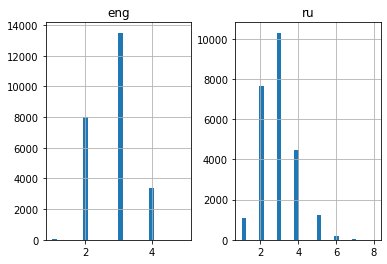

In [65]:
length_df.hist(bins = 30)
plt.show()

In [66]:
max_eng=max(eng_l)
max_ru=max(ru_l)
print("Maximum length in English:",max_eng)
print("Maximum length in Russian:",max_ru)

Maximum length in English: 5
Maximum length in Russian: 8


In [0]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [68]:
# prepare english tokenizer
eng_tokenizer = tokenization(ru_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = max_eng
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 2617


In [69]:
# prepare Russian tokenizer
ru_tokenizer = tokenization(ru_eng[:, 1])
ru_vocab_size = len(ru_tokenizer.word_index) + 1

ru_length = max_ru
print('Russian Vocabulary Size: %d' % ru_vocab_size)

Russian Vocabulary Size: 6441


In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ru_eng, test_size=0.2, random_state = 12)

In [0]:
# prepare training data
trainX = encode_sequences(ru_tokenizer, ru_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

In [0]:
# prepare validation data
testX = encode_sequences(ru_tokenizer, ru_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [0]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps)) #to increase dimension
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [75]:
model = build_model(ru_vocab_size, eng_vocab_size, ru_length, eng_length, 512)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 8, 512)            3297792   
_________________________________________________________________
lstm_3 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 5, 512)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 512)            2099200   
_________________________________________________________________
dense_2 (Dense)              (None, 5, 2617)           1342521   
Total params: 8,838,713
Trainable params: 8,838,713
Non-trainable params: 0
_________________________________________________________________


In [0]:

rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [77]:
filename = 'model.h1.24_jan_19'
#checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=128, 
          validation_split = 0.2, verbose=1)
          #callbacks=[checkpoint], verbose=1)

Train on 16000 samples, validate on 4000 samples
Epoch 1/30
16000/16000 [==============================] - 7s 423us/step - loss: 3.5793 - val_loss: 3.1274
Epoch 2/30
16000/16000 [==============================] - 5s 306us/step - loss: 2.8733 - val_loss: 2.6978
Epoch 3/30
16000/16000 [==============================] - 5s 307us/step - loss: 2.4561 - val_loss: 2.3608
Epoch 4/30
16000/16000 [==============================] - 5s 304us/step - loss: 2.1149 - val_loss: 2.1337
Epoch 5/30
16000/16000 [==============================] - 5s 305us/step - loss: 1.8559 - val_loss: 1.9678
Epoch 6/30
16000/16000 [==============================] - 5s 306us/step - loss: 1.6376 - val_loss: 1.8327
Epoch 7/30
16000/16000 [==============================] - 5s 312us/step - loss: 1.4481 - val_loss: 1.7039
Epoch 8/30
16000/16000 [==============================] - 5s 313us/step - loss: 1.2747 - val_loss: 1.6044
Epoch 9/30
16000/16000 [==============================] - 5s 307us/step - loss: 1.1226 - val_loss: 1.50

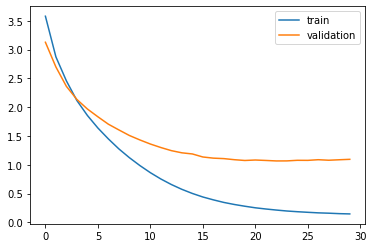

In [78]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [0]:
#model.save('/content/drive/My Drive/Colab Notebooks/ruengmodel.h1.02_mar_20')

In [0]:
#model = load_model('/content/drive/My Drive/Colab Notebooks/ruengmodel.h1.02_mar_20')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [82]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        print(t)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

Streaming output truncated to the last 5000 lines.
you
do
it
None
i
am
sweaty
None
None
ill
kill
you
None
None
youd
him
it
None
None
youre
lost
None
None
None
we
must
leave
None
None
i
like
the
hat
None
i
remember
her
None
None
start
singing
None
None
None
hes
a
big
liar
None
have
you
eaten
None
None
am
i
fat
None
None
im
just
lucky
None
None
tom
looks
ok
None
None
youre
trying
None
None
None
stay
quiet
None
None
None
i
am
better
None
None
he
has
a
flaw
None
im
busy
today
None
None
thats
a
a
None
None
tom
got
robbed
None
None
what
did
it
it
None
tom
will
None
None
None
arent
not
cute
None
None
get
up
up
None
None
ill
call
tom
None
None
youre
stuck
None
None
None
go
with
tom
None
None
make
it
simple
None
None
youre
odd
None
None
None
i
love
it
here
None
ill
sue
you
None
None
what
a
phony
None
None
you
stay
there
None
None
they
sweated
None
None
None
ill
teach
you
None
None
youre
nice
None
None
None
its
is
None
None
None
it
work
survive
None
None
im
inside
None
None
None
youre
precise
No

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 200)

In [85]:
pred_df.tail(15)

,actual,predicted
4985,you are rude,she is rude
4986,drink something,drink something
4987,get away,go away
4988,was tom asleep,tom was working
4989,tom is creepy,tom is glad
4990,i paused,i got fun
4991,ask tom again,tell it tom
4992,i came alone,i came alone
4993,a beer please,coffee please
4994,stop filming,stop filming


In [86]:
pred_df.sample(20)

,actual,predicted
718,come here,get over here
1658,thats so nice,its so wild
806,listen to me,will
4550,i was an idiot,i had a had
3718,replace it,it will
1453,i was anxious,i was anxious
4240,turn on the tv,turn up the tv
1999,send me there,send me there
3575,youre so late,youre so late
8,hold this,keep this


In [87]:
testX.shape

(5000, 8)